# Method 4 - Best Ideas Medium Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Market Cap Adjusted Target

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance Adjusted Intra-Cap Weight Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data[
    'weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['herf_pct'] > (1 / 3)) & (best_ideas['herf_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

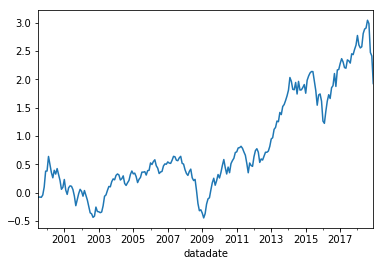

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.377104
2000-12-31   -0.207023
2001-12-31   -0.032724
2002-12-31   -0.370481
2003-12-31    0.841744
2004-12-31    0.126829
2005-12-31    0.009666
2006-12-31    0.076768
2007-12-31    0.001254
2008-12-31   -0.537308
2009-12-31    0.896300
2010-12-31    0.295206
2011-12-31   -0.143338
2012-12-31    0.241455
2013-12-31    0.491270
2014-12-31    0.074044
2015-12-31   -0.100469
2016-12-31    0.213551
2017-12-31    0.135378
2018-12-31   -0.188171
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     528.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.36e-114
Time:                        11:37:42   Log-Likelihood:                 541.14
No. Observations:                 234   AIC:                            -1072.
Df Residuals:                     229   BIC:                            -1055.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.002      2.128      0.034       0.000       0.007
mktrf          1.1313      0.045     25.048      0.000       1.042       1.220
me             0.5510      0.053     10.487      0.000       0.447       0.654
ia            -0.0465      0.080     -0.582      0.561      -0.204       0.111
roe           -0.7119      0.068    -10.415      0.000      -0.847      -0.577
==============================================================================
Omnibus:                       64.533   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.923
Skew:                           1.105   Prob(JB):                     5.30e-50
Kurtosis:                       7.288   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     341.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.79e-95
Time:                        11:37:42   Log-Likelihood:                 541.14
No. Observations:                 234   AIC:                            -1072.
Df Residuals:                     229   BIC:                            -1055.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.002      1.939      0.053   -3.83e-05       0.007
mktrf          1.1313      0.045     25.201      0.000       1.043       1.219
me             0.5510      0.046     11.954      0.000       0.461       0.641
ia            -0.0465      0.137     -0.341      0.733      -0.314       0.221
roe           -0.7119      0.136     -5.239      0.000      -0.978      -0.446
==============================================================================
Omnibus:                       64.533   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.923
Skew:                           1.105   Prob(JB):                     5.30e-50
Kurtosis:                       7.288   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     474.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.69e-109
Time:                        11:37:42   Log-Likelihood:                 541.14
No. Observations:                 234   AIC:                            -1072.
Df Residuals:                     229   BIC:                            -1055.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.002      2.099      0.036       0.000       0.007
mktrf          1.1313      0.046     24.696      0.000       1.042       1.221
me             0.5510      0.049     11.285      0.000       0.455       0.647
ia            -0.0465      0.115     -0.404      0.686      -0.272       0.179
roe           -0.7119      0.148     -4.826      0.000      -1.001      -0.423
==============================================================================
Omnibus:                       64.533   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.923
Skew:                           1.105   Prob(JB):                     5.30e-50
Kurtosis:                       7.288   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     360.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.77e-106
Time:                        11:37:42   Log-Likelihood:                 524.77
No. Observations:                 234   AIC:                            -1038.
Df Residuals:                     228   BIC:                            -1017.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.502      0.134      -0.001       0.006
mktrf          1.2153      0.049     24.984      0.000       1.119       1.311
smb            0.6033      0.064      9.401      0.000       0.477       0.730
hml            0.0820      0.076      1.083      0.280      -0.067       0.231
rmw           -0.6004      0.086     -7.017      0.000      -0.769      -0.432
cma            0.0009      0.109      0.008      0.993      -0.213       0.215
==============================================================================
Omnibus:                       65.224   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              222.314
Skew:                           1.130   Prob(JB):                     5.31e-49
Kurtosis:                       7.207   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     173.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.56e-75
Time:                        11:37:42   Log-Likelihood:                 524.77
No. Observations:                 234   AIC:                            -1038.
Df Residuals:                     228   BIC:                            -1017.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.416      0.157      -0.001       0.006
mktrf          1.2153      0.049     24.566      0.000       1.118       1.312
smb            0.6033      0.060     10.056      0.000       0.486       0.721
hml            0.0820      0.103      0.796      0.426      -0.120       0.284
rmw           -0.6004      0.150     -4.004      0.000      -0.894      -0.307
cma            0.0009      0.165      0.005      0.996      -0.323       0.325
==============================================================================
Omnibus:                       65.224   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              222.314
Skew:                           1.130   Prob(JB):                     5.31e-49
Kurtosis:                       7.207   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     196.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.92e-80
Time:                        11:37:42   Log-Likelihood:                 524.77
No. Observations:                 234   AIC:                            -1038.
Df Residuals:                     228   BIC:                            -1017.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.002      1.455      0.146      -0.001       0.006
mktrf          1.2153      0.052     23.215      0.000       1.113       1.318
smb            0.6033      0.054     11.081      0.000       0.497       0.710
hml            0.0820      0.087      0.948      0.343      -0.088       0.252
rmw           -0.6004      0.162     -3.703      0.000      -0.918      -0.283
cma            0.0009      0.149      0.006      0.995      -0.291       0.292
==============================================================================
Omnibus:                       65.224   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              222.314
Skew:                           1.130   Prob(JB):                     5.31e-49
Kurtosis:                       7.207   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     422.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.10e-104
Time:                        11:37:42   Log-Likelihood:                 517.70
No. Observations:                 234   AIC:                            -1025.
Df Residuals:                     229   BIC:                            -1008.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.536      0.592      -0.003       0.004
mktrf          1.2639      0.046     27.496      0.000       1.173       1.354
smb            0.8535      0.057     14.875      0.000       0.740       0.967
hml           -0.0191      0.057     -0.336      0.738      -0.131       0.093
umd           -0.2233      0.037     -5.971      0.000      -0.297      -0.150
==============================================================================
Omnibus:                       64.939   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.194
Skew:                           1.042   Prob(JB):                     1.06e-60
Kurtosis:                       7.898   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     212.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.49e-76
Time:                        11:37:42   Log-Likelihood:                 517.70
No. Observations:                 234   AIC:                            -1025.
Df Residuals:                     229   BIC:                            -1008.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.540      0.589      -0.003       0.004
mktrf          1.2639      0.053     23.753      0.000       1.160       1.368
smb            0.8535      0.063     13.579      0.000       0.730       0.977
hml           -0.0191      0.094     -0.204      0.839      -0.203       0.165
umd           -0.2233      0.074     -3.017      0.003      -0.368      -0.078
==============================================================================
Omnibus:                       64.939   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.194
Skew:                           1.042   Prob(JB):                     1.06e-60
Kurtosis:                       7.898   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     226.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.32e-78
Time:                        11:37:42   Log-Likelihood:                 517.70
No. Observations:                 234   AIC:                            -1025.
Df Residuals:                     229   BIC:                            -1008.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.621      0.535      -0.002       0.004
mktrf          1.2639      0.048     26.194      0.000       1.169       1.358
smb            0.8535      0.063     13.449      0.000       0.729       0.978
hml           -0.0191      0.081     -0.237      0.812      -0.177       0.139
umd           -0.2233      0.073     -3.066      0.002      -0.366      -0.081
==============================================================================
Omnibus:                       64.939   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              276.194
Skew:                           1.042   Prob(JB):                     1.06e-60
Kurtosis:                       7.898   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     253.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.31e-56
Time:                        11:37:42   Log-Likelihood:                 255.84
No. Observations:                 120   AIC:                            -501.7
Df Residuals:                     115   BIC:                            -487.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.003      1.854      0.066      -0.000       0.011
mktrf          1.1663      0.076     15.436      0.000       1.017       1.316
me             0.5352      0.075      7.171      0.000       0.387       0.683
ia            -0.0560      0.117     -0.479      0.633      -0.288       0.175
roe           -0.6622      0.103     -6.402      0.000      -0.867      -0.457
==============================================================================
Omnibus:                       34.325   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.360
Skew:                           1.097   Prob(JB):                     7.92e-19
Kurtosis:                       6.444   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     165.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.54e-47
Time:                        11:37:42   Log-Likelihood:                 255.84
No. Observations:                 120   AIC:                            -501.7
Df Residuals:                     115   BIC:                            -487.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.003      1.658      0.097      -0.001       0.011
mktrf          1.1663      0.073     15.899      0.000       1.023       1.310
me             0.5352      0.063      8.471      0.000       0.411       0.659
ia            -0.0560      0.188     -0.298      0.766      -0.424       0.312
roe           -0.6622      0.187     -3.537      0.000      -1.029      -0.295
==============================================================================
Omnibus:                       34.325   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.360
Skew:                           1.097   Prob(JB):                     7.92e-19
Kurtosis:                       6.444   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     227.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.33e-53
Time:                        11:37:42   Log-Likelihood:                 255.84
No. Observations:                 120   AIC:                            -501.7
Df Residuals:                     115   BIC:                            -487.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.003      1.803      0.071      -0.000       0.011
mktrf          1.1663      0.079     14.847      0.000       1.012       1.320
me             0.5352      0.069      7.771      0.000       0.400       0.670
ia            -0.0560      0.163     -0.344      0.731      -0.375       0.263
roe           -0.6622      0.205     -3.225      0.001      -1.065      -0.260
==============================================================================
Omnibus:                       34.325   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.360
Skew:                           1.097   Prob(JB):                     7.92e-19
Kurtosis:                       6.444   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     187.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.12e-53
Time:                        11:37:42   Log-Likelihood:                 252.10
No. Observations:                 120   AIC:                            -492.2
Df Residuals:                     114   BIC:                            -475.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.003      1.858      0.066      -0.000       0.011
mktrf          1.3226      0.083     16.020      0.000       1.159       1.486
smb            0.6095      0.094      6.519      0.000       0.424       0.795
hml           -0.0148      0.115     -0.129      0.897      -0.242       0.212
rmw           -0.4842      0.135     -3.584      0.001      -0.752      -0.217
cma            0.0846      0.148      0.572      0.569      -0.209       0.378
==============================================================================
Omnibus:                       33.155   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.055
Skew:                           1.096   Prob(JB):                     8.30e-17
Kurtosis:                       6.164   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     120.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.15e-44
Time:                        11:37:43   Log-Likelihood:                 252.10
No. Observations:                 120   AIC:                            -492.2
Df Residuals:                     114   BIC:                            -475.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.003      1.922      0.055      -0.000       0.011
mktrf          1.3226      0.067     19.624      0.000       1.190       1.455
smb            0.6095      0.084      7.297      0.000       0.446       0.773
hml           -0.0148      0.126     -0.117      0.907      -0.262       0.233
rmw           -0.4842      0.199     -2.435      0.015      -0.874      -0.095
cma            0.0846      0.185      0.457      0.648      -0.278       0.448
==============================================================================
Omnibus:                       33.155   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.055
Skew:                           1.096   Prob(JB):                     8.30e-17
Kurtosis:                       6.164   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     193.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.36e-54
Time:                        11:37:43   Log-Likelihood:                 252.10
No. Observations:                 120   AIC:                            -492.2
Df Residuals:                     114   BIC:                            -475.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.003      2.029      0.042       0.000       0.011
mktrf          1.3226      0.060     22.031      0.000       1.205       1.440
smb            0.6095      0.075      8.077      0.000       0.462       0.757
hml           -0.0148      0.117     -0.126      0.900      -0.245       0.215
rmw           -0.4842      0.219     -2.211      0.027      -0.913      -0.055
cma            0.0846      0.154      0.551      0.582      -0.216       0.386
==============================================================================
Omnibus:                       33.155   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.055
Skew:                           1.096   Prob(JB):                     8.30e-17
Kurtosis:                       6.164   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     231.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.58e-54
Time:                        11:37:43   Log-Likelihood:                 251.18
No. Observations:                 120   AIC:                            -492.4
Df Residuals:                     115   BIC:                            -478.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.003      1.295      0.198      -0.002       0.009
mktrf          1.3443      0.069     19.425      0.000       1.207       1.481
smb            0.8385      0.079     10.642      0.000       0.682       0.995
hml           -0.0527      0.079     -0.668      0.505      -0.209       0.104
umd           -0.1995      0.049     -4.099      0.000      -0.296      -0.103
==============================================================================
Omnibus:                       34.415   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.622
Skew:                           1.018   Prob(JB):                     1.41e-22
Kurtosis:                       6.998   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     149.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.18e-44
Time:                        11:37:43   Log-Likelihood:                 251.18
No. Observations:                 120   AIC:                            -492.4
Df Residuals:                     115   BIC:                            -478.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.003      1.321      0.186      -0.002       0.009
mktrf          1.3443      0.071     18.925      0.000       1.205       1.484
smb            0.8385      0.086      9.707      0.000       0.669       1.008
hml           -0.0527      0.122     -0.431      0.666      -0.292       0.187
umd           -0.1995      0.085     -2.354      0.019      -0.365      -0.033
==============================================================================
Omnibus:                       34.415   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.622
Skew:                           1.018   Prob(JB):                     1.41e-22
Kurtosis:                       6.998   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     183.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.63e-49
Time:                        11:37:43   Log-Likelihood:                 251.18
No. Observations:                 120   AIC:                            -492.4
Df Residuals:                     115   BIC:                            -478.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      1.564      0.118      -0.001       0.008
mktrf          1.3443      0.056     24.144      0.000       1.235       1.453
smb            0.8385      0.089      9.384      0.000       0.663       1.014
hml           -0.0527      0.111     -0.473      0.636      -0.271       0.166
umd           -0.1995      0.080     -2.491      0.013      -0.356      -0.043
==============================================================================
Omnibus:                       34.415   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.622
Skew:                           1.018   Prob(JB):                     1.41e-22
Kurtosis:                       6.998   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     297.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.24e-57
Time:                        11:37:43   Log-Likelihood:                 301.42
No. Observations:                 114   AIC:                            -592.8
Df Residuals:                     109   BIC:                            -579.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.271      0.206      -0.001       0.006
mktrf          1.1008      0.052     21.289      0.000       0.998       1.203
me             0.5822      0.080      7.293      0.000       0.424       0.740
ia            -0.0787      0.111     -0.711      0.479      -0.298       0.141
roe           -0.8341      0.097     -8.572      0.000      -1.027      -0.641
==============================================================================
Omnibus:                        6.403   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                6.426
Skew:                           0.407   Prob(JB):                       0.0402
Kurtosis:                       3.831   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     707.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.56e-77
Time:                        11:37:43   Log-Likelihood:                 301.42
No. Observations:                 114   AIC:                            -592.8
Df Residuals:                     109   BIC:                            -579.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.002      1.478      0.139      -0.001       0.005
mktrf          1.1008      0.049     22.643      0.000       1.006       1.196
me             0.5822      0.051     11.316      0.000       0.481       0.683
ia            -0.0787      0.117     -0.674      0.501      -0.308       0.150
roe           -0.8341      0.097     -8.637      0.000      -1.023      -0.645
==============================================================================
Omnibus:                        6.403   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                6.426
Skew:                           0.407   Prob(JB):                       0.0402
Kurtosis:                       3.831   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     1226.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.33e-89
Time:                        11:37:43   Log-Likelihood:                 301.42
No. Observations:                 114   AIC:                            -592.8
Df Residuals:                     109   BIC:                            -579.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.609      0.108      -0.000       0.005
mktrf          1.1008      0.041     27.150      0.000       1.021       1.180
me             0.5822      0.040     14.398      0.000       0.503       0.661
ia            -0.0787      0.118     -0.668      0.504      -0.310       0.152
roe           -0.8341      0.078    -10.665      0.000      -0.987      -0.681
==============================================================================
Omnibus:                        6.403   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                6.426
Skew:                           0.407   Prob(JB):                       0.0402
Kurtosis:                       3.831   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     175.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.32e-50
Time:                        11:37:43   Log-Likelihood:                 286.40
No. Observations:                 114   AIC:                            -560.8
Df Residuals:                     108   BIC:                            -544.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.124      0.902      -0.004       0.004
mktrf          1.1427      0.057     20.218      0.000       1.031       1.255
smb            0.6035      0.092      6.577      0.000       0.422       0.785
hml            0.1504      0.117      1.286      0.201      -0.082       0.382
rmw           -0.7142      0.143     -4.984      0.000      -0.998      -0.430
cma           -0.0912      0.182     -0.501      0.617      -0.452       0.269
==============================================================================
Omnibus:                        0.324   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.850   Jarque-Bera (JB):                0.156
Skew:                           0.088   Prob(JB):                        0.925
Kurtosis:                       3.041   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     145.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.76e-46
Time:                        11:37:43   Log-Likelihood:                 286.40
No. Observations:                 114   AIC:                            -560.8
Df Residuals:                     108   BIC:                            -544.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.125      0.900      -0.004       0.004
mktrf          1.1427      0.063     18.092      0.000       1.019       1.266
smb            0.6035      0.076      7.939      0.000       0.455       0.752
hml            0.1504      0.160      0.940      0.347      -0.163       0.464
rmw           -0.7142      0.203     -3.524      0.000      -1.111      -0.317
cma           -0.0912      0.175     -0.522      0.602      -0.433       0.251
==============================================================================
Omnibus:                        0.324   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.850   Jarque-Bera (JB):                0.156
Skew:                           0.088   Prob(JB):                        0.925
Kurtosis:                       3.041   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     220.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.48e-55
Time:                        11:37:43   Log-Likelihood:                 286.40
No. Observations:                 114   AIC:                            -560.8
Df Residuals:                     108   BIC:                            -544.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.127      0.899      -0.004       0.004
mktrf          1.1427      0.064     17.987      0.000       1.018       1.267
smb            0.6035      0.067      9.059      0.000       0.473       0.734
hml            0.1504      0.172      0.873      0.383      -0.187       0.488
rmw           -0.7142      0.205     -3.482      0.000      -1.116      -0.312
cma           -0.0912      0.190     -0.479      0.632      -0.464       0.281
==============================================================================
Omnibus:                        0.324   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.850   Jarque-Bera (JB):                0.156
Skew:                           0.088   Prob(JB):                        0.925
Kurtosis:                       3.041   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     187.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.14e-48
Time:                        11:37:43   Log-Likelihood:                 278.03
No. Observations:                 114   AIC:                            -546.1
Df Residuals:                     109   BIC:                            -532.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.253      0.801      -0.005       0.004
mktrf          1.1715      0.060     19.472      0.000       1.052       1.291
smb            0.7752      0.094      8.263      0.000       0.589       0.961
hml            0.1492      0.097      1.545      0.125      -0.042       0.341
umd           -0.2109      0.073     -2.894      0.005      -0.355      -0.066
==============================================================================
Omnibus:                        9.758   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               12.152
Skew:                           0.480   Prob(JB):                      0.00230
Kurtosis:                       4.279   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     181.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.44e-47
Time:                        11:37:43   Log-Likelihood:                 278.03
No. Observations:                 114   AIC:                            -546.1
Df Residuals:                     109   BIC:                            -532.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.309      0.757      -0.004       0.003
mktrf          1.1715      0.061     19.254      0.000       1.052       1.291
smb            0.7752      0.085      9.141      0.000       0.609       0.941
hml            0.1492      0.160      0.934      0.350      -0.164       0.462
umd           -0.2109      0.073     -2.875      0.004      -0.355      -0.067
==============================================================================
Omnibus:                        9.758   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               12.152
Skew:                           0.480   Prob(JB):                      0.00230
Kurtosis:                       4.279   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     178.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.56e-47
Time:                        11:37:43   Log-Likelihood:                 278.03
No. Observations:                 114   AIC:                            -546.1
Df Residuals:                     109   BIC:                            -532.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.002     -0.322      0.747      -0.004       0.003
mktrf          1.1715      0.057     20.490      0.000       1.059       1.284
smb            0.7752      0.068     11.470      0.000       0.643       0.908
hml            0.1492      0.165      0.902      0.367      -0.175       0.474
umd           -0.2109      0.063     -3.374      0.001      -0.333      -0.088
==============================================================================
Omnibus:                        9.758   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               12.152
Skew:                           0.480   Prob(JB):                      0.00230
Kurtosis:                       4.279   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""